# CP321-ILR: Assigment-9

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from utils.helpers import load_data3, plot_trajectories
from utils.models import TPGMM
from utils.utils import *

# TPGMM Implementation

#### theory reference : [1](https://ieeexplore.ieee.org/document/6907339),[2](https://calinon.ch/papers/Calinon-JIST2015.pdf)

In [2]:
Data, time = load_data3("c")

Data.shape=(7, 1000, 3)


As.shape=(2, 7, 3, 3)
Bs.shape=(2, 7, 3)


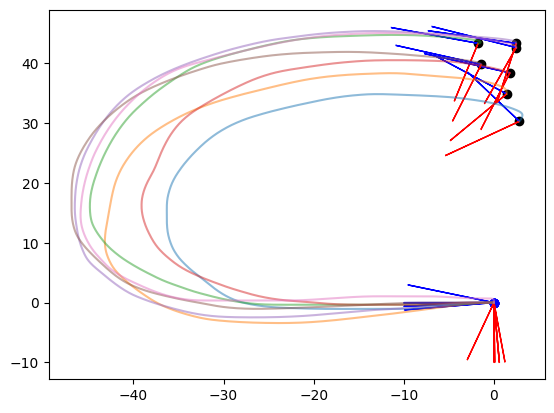

In [ ]:
As, Bs = plot_trajectories(Data)

In [19]:
mp = TPGMM(As, Bs, 4)
mp.fit(Data)

Epoch:0 Log likelihood: -78262.83447518575 improvement 2698.9467466845526
Epoch:1 Log likelihood: -78182.50144079581 improvement 80.33303438994335
Epoch:2 Log likelihood: -78049.83358163989 improvement 132.66785915591754
Epoch:3 Log likelihood: -77946.95763196581 improvement 102.87594967408222
Epoch:4 Log likelihood: -77938.50536924168 improvement 8.452262724124012
Epoch:5 Log likelihood: -77936.73545764032 improvement 1.7699116013682215
Epoch:6 Log likelihood: -77935.89064449922 improvement 0.8448131410987116
Epoch:7 Log likelihood: -77934.82853339614 improvement 1.0621111030777683
Epoch:8 Log likelihood: -77933.36650847542 improvement 1.4620249207218876
Epoch:9 Log likelihood: -77931.51034636926 improvement 1.856162106152624
Epoch:10 Log likelihood: -77929.29035535632 improvement 2.219991012942046
Epoch:11 Log likelihood: -77926.7375131379 improvement 2.55284221842885
Epoch:12 Log likelihood: -77923.88356466961 improvement 2.853948468284216
Epoch:13 Log likelihood: -77920.76239797912

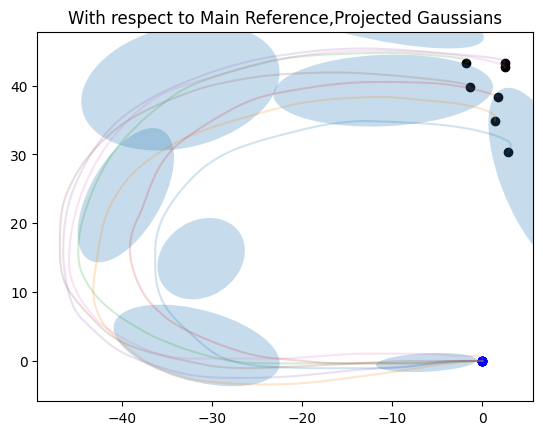

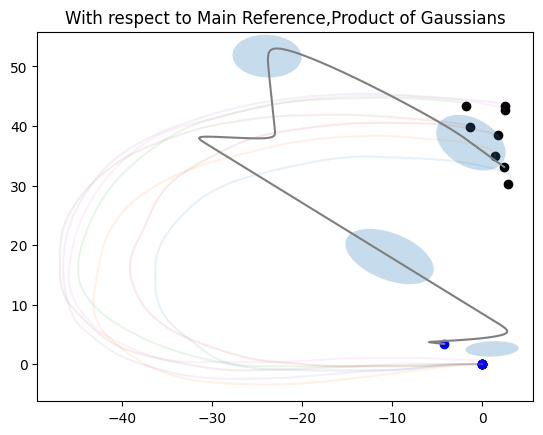

In [20]:
# using old params of trajectory 1
A_new, B_new = As[:, 0], Bs[:, 0]
mp.plot_gaussians_wrt_frames(Data, A_new, B_new)

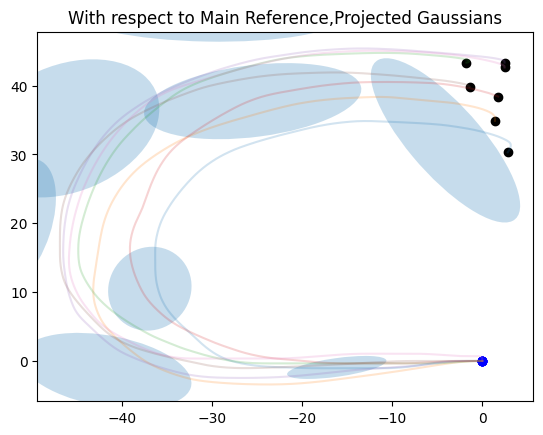

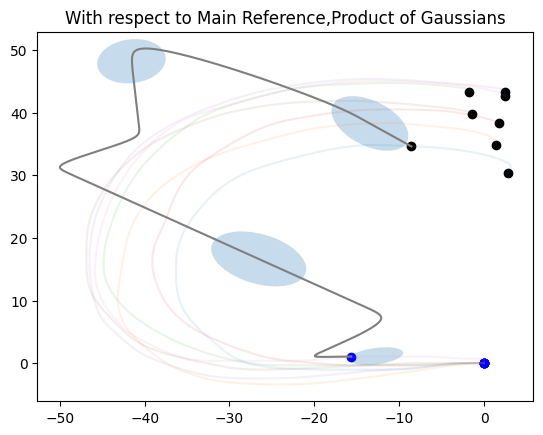

In [21]:
# translating start and end of the trajectory - 2  by -10
A_new, B_new = As[:, 1].copy(), Bs[:, 1].copy()
B_new[0] = B_new[0] + np.array([0, -10, 0])
B_new[1] = B_new[1] + np.array([0, -10, 0])
mp.plot_gaussians_wrt_frames(Data, A_new, B_new)

## Dataset "C"

### 1. Different start and end points

Try different start and end points for particular trajectory.

#### Plots

### 3. Generalization of the algorithm

Try changing the `n_mixture` parameter and comment on the generalization of the algorithm.

#### Plots

#### Analysis

## Dataset "J"

### 1. Different start and end points

Try different start and end points for particular trajectory.

#### Plots

### 3. Generalization of the algorithm

Try changing the `n_mixture` parameter and comment on the generalization of the algorithm.

#### Plots

#### Analysis

## Dataset "S"

### 1. Different start and end points

Try different start and end points for particular trajectory.

#### Plots

### 3. Generalization of the algorithm

Try changing the `n_mixture` parameter and comment on the generalization of the algorithm.

#### Plots

#### Analysis